# Creating a world map of metal bands in Python

When I found the [Metal Bands by Nation dataset](https://www.kaggle.com/mrpantherson/metal-by-nation), I thought it would be an interesting and quick task to create a world map of metal bands similar to [this one](https://i.imgur.com/P5Yfz.png) created by [redditor u/depo\_ 6 years ago](https://www.reddit.com/r/Metal/comments/q2flb/map_of_countries_by_metal_bands_per_capita/). But as usual there is some effort required to prepare the data, i. e. remove duplicates, cope with different names for the same entity etc. In this notebook, I document the process and the particular pitfalls I came across in this dataset.

## Load and prepare bands data

In the first step we load the metal bands data into a pandas DataFrame, only using the relevant columns, and show the top bands by the number of fans on the website [metalstorm.net](http://metalstorm.net/), which is the original source of the data.

In [1]:
%matplotlib inline
import os
import pandas as pd

bands_cols = ['band_name', 'fans', 'origin', 'split']
filename = os.path.expanduser('~/data/kaggle.com/mrpantherson/metal-by-nation/metal_bands_2017.csv')
bands = pd.read_csv(filename, encoding='latin-1', usecols=bands_cols)
bands.sort_values('fans', ascending=False).head(10)

,band_name,fans,origin,split
0,Iron Maiden,4195,United Kingdom,-
50,Iron Maiden,4195,United Kingdom,-
51,Opeth,4147,Sweden,1990
1,Opeth,4147,Sweden,1990
52,Metallica,3712,USA,-
2,Metallica,3712,USA,-
3,Megadeth,3105,USA,1983
53,Megadeth,3105,USA,1983
4,Amon Amarth,3054,Sweden,-
54,Amon Amarth,3054,Sweden,-


It is immediately obvious that this dataset cannot be used as is, because there are duplicate values. Let's see how many.

In [2]:
len(bands), len(bands.drop_duplicates())

(5000, 4950)

It is easy to remove duplicates in pandas and while we are at it, we will also drop rows without an ``origin`` value.

In [3]:
bands.drop_duplicates(inplace=True)
bands.dropna(subset=['origin'], inplace=True)
len(bands)

4942

Now we'll deal with the problem of country name variations. The bands data uses country names, which is fine when you work with only one dataset, but almost certainly will cause problems when you deal with multiple datasets and country names act as the common key.  Since the geo data we'll use later contains [ISO 3166-1 alpha-3 country codes](https://en.wikipedia.org/wiki/ISO_3166-1_alpha-3) values to identify countries, we want to add these codes to our bands data as well. 

We use the [geonamescache](https://github.com/yaph/geonamescache) package to help with this task. First let's see if there are country names in the bands dataset, which cannot be easily mapped to ISO codes.

In [4]:
from geonamescache import GeonamesCache

countries = GeonamesCache().get_countries_by_names()
sorted(set(bands.origin.unique()) - set(countries.keys()))

['Australia, United Kingdom',
 'Belgium, United Kingdom',
 'Bosnia and Herzegovina, Croatia',
 'Canada, France',
 'Colombia, USA',
 'Czech Republic',
 'Denmark, USA',
 'Finland, Sweden',
 'Greece, Sweden',
 'Greece, USA',
 'Hungary, United Kingdom',
 'Iran, Norway',
 'Iraq, USA',
 'Israel, Germany',
 'Israel, The Netherlands',
 'Italy, Spain',
 'Korea, South',
 'Kyrgyzstan, Germany',
 'Lithuania, Germany',
 'Lithuania, United Kingdom',
 'Mexico, USA',
 'Norway, Finland',
 'Poland, Sweden',
 'Portugal, United Kingdom',
 'Russia, Canada',
 'Slovak Republic',
 'Sweden, Finland',
 'The Netherlands',
 'Tunisia, France',
 'UAE',
 'USA',
 'USA, Cyprus',
 'Ukraine, Canada',
 'United Kingdom, Greece',
 'United Kingdom, USA']

Several distinct origin values are not in ``countries``, most of them are actually multiple country names, separated by commas, e. g. ``Australia, United Kingdom``, ``Denmark, USA``, but then there is also ``Korea, South``, where the comma is part of a single name. Let's look at some records containing multiple countries:

In [5]:
bands[bands['origin'].isin(['Australia, United Kingdom', 'Denmark, USA'])]

,band_name,fans,origin,split
159,King Diamond,641,"Denmark, USA",1985
194,Mercyful Fate,525,"Denmark, USA",-
588,Deströyer 666,124,"Australia, United Kingdom",-


I don't know metalstorm's criteria for designating the origin, but it does not seem to be the birth countries of band members otherwise bands like Metallica and AC/DC should show up above.

Anyway, we need to handle these records and split them up so that there will be two entries for ``King Diamond``, one with ``Denmark`` and one with ``USA`` as ``origin`` values. To prevent this for ``Korea, South`` we replace it with a name that has no comma first. I found the approach you see below [on Stack Overflow](https://stackoverflow.com/questions/17116814/pandas-how-do-i-split-text-in-a-column-into-multiple-rows/21032532). We end up with a new column ``country`` with single country name values.

In [6]:
bands.loc[bands['origin'] == 'Korea, South', 'origin'] = 'South Korea'

s = bands['origin'].str.split(',').apply(pd.Series, 1).stack().str.strip()
s.index = s.index.droplevel(-1)
s.name = 'country'
bands = bands.join(s)

sorted(set(bands.country.unique()) - set(countries.keys()))

['Czech Republic', 'Slovak Republic', 'The Netherlands', 'UAE', 'USA']

Next, we create an index that maps country names to codes, add the remaining unresolved names manually, and then add a new column called ``iso3`` to the ``bands`` DataFrame and make sure, there are no more missing values left.

In [7]:
from geonamescache.mappers import country

mapper = country(from_key='name', to_key='iso3')

country_index = {}
country_index['Czech Republic'] = 'CZE'
country_index['Slovak Republic'] = 'SVK'
country_index['The Netherlands'] = 'NLD'
country_index['UAE'] = 'ARE'
country_index['USA'] = 'USA'

bands['iso3'] = bands.country.apply(lambda x: country_index.get(x, mapper(x)))
assert all(~bands['iso3'].isna())
bands.head()

,band_name,fans,origin,split,country,iso3
0,Iron Maiden,4195,United Kingdom,-,United Kingdom,GBR
1,Opeth,4147,Sweden,1990,Sweden,SWE
2,Metallica,3712,USA,-,USA,USA
3,Megadeth,3105,USA,1983,USA,USA
4,Amon Amarth,3054,Sweden,-,Sweden,SWE


## Load geo data and combine the datasets

Next we create a [GeoDataFrame](http://geopandas.org/data_structures.html#geodataframe) containing geo and population data from [naturalearthdata.com](http://www.naturalearthdata.com/), set the map projection to [Robinson](https://en.wikipedia.org/wiki/Robinson_projection) and remove Antarctica so it doesn't take up unnecessary space.  Then we calculate and add the count of bands per country and bands per 1 million people values.

In [8]:
import fiona

In [9]:
import geopandas as gpd

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).to_crs('+proj=robin')
world = world[world.name != 'Antarctica']

counts = bands.iso3.value_counts()
counts.name = 'bands'
world = world.join(counts, on='iso_a3')

world['band_ratio'] = world['bands'] / world['pop_est'] * 1_000_000
world.sort_values('band_ratio', ascending=False).head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,bands,band_ratio
77,306694.0,Europe,Iceland,ISL,12710.0,"POLYGON ((-1025302.196888561 6952546.77166883,...",25.0,81.514474
52,5250275.0,Europe,Finland,FIN,193500.0,"POLYGON ((1962483.96119979 7191405.689743098, ...",303.0,57.711263
151,9059651.0,Europe,Sweden,SWE,344300.0,"POLYGON ((1580026.141474696 6884344.137279728,...",475.0,52.430276
118,4676305.0,Europe,Norway,NOR,276400.0,(POLYGON ((1885031.797202721 7380292.033532551...,220.0,47.045691
65,57600.0,North America,Greenland,GRL,1100.0,POLYGON ((-2627201.179858952 8280938.168229437...,1.0,17.361111


## Plot the map

We'll use the handy ``plot`` method available on ``GeoDataFrame`` objects. To make sure the map shows all countries, including those without data on metal bands, we have to plot these two sets separately. If you like to learn why, check out this notebook on [creating choropleth maps using GeoPandas](http://ramiro.org/notebook/geopandas-choropleth/).

In the final code section, we create two separate data frames ``known`` and ``unknown``. The ``known`` countries will be plotted using a colormap that seemed appropriate and the [Jenks classification method](https://en.wikipedia.org/wiki/Jenks_natural_breaks_optimization), that reduces the variance within classes and maximize the variance between classes. There will be ``9`` different classes with darker colors indicating higher band ratios.

The ``unknown`` countries will be shown with a white background and a striped pattern. We also add some descriptive text, move the legend to the lower left part of the map and set the legend's size.

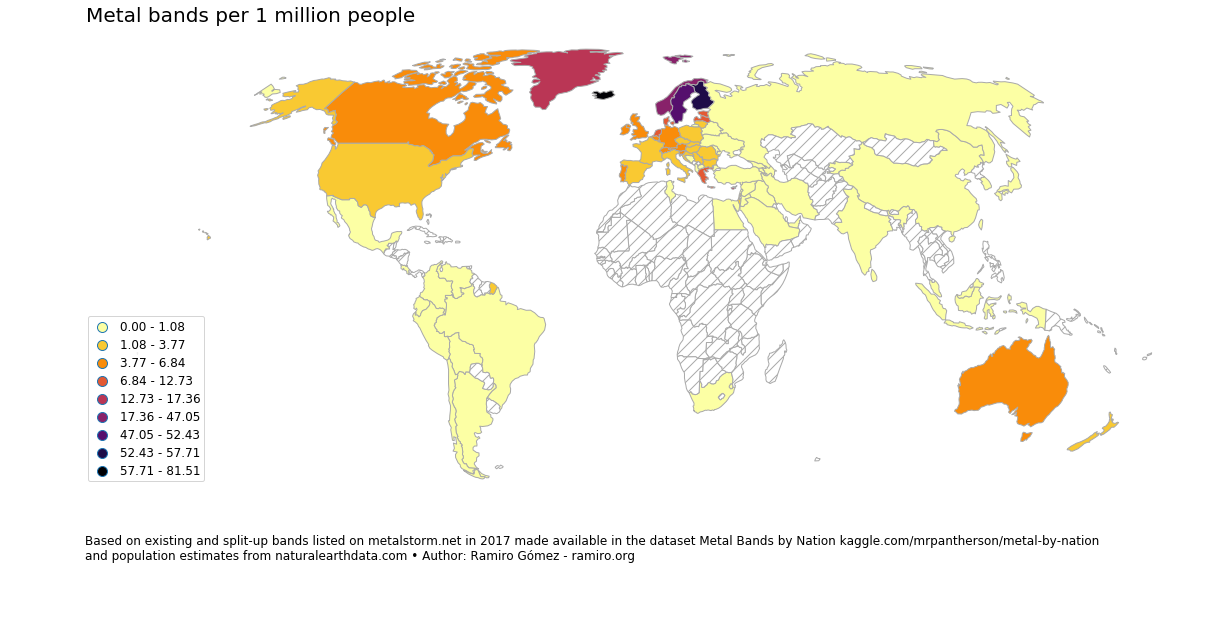

In [10]:
known = world.dropna(subset=['band_ratio'])
unknown = world[world['band_ratio'].isna()]

ax = known.plot(column='band_ratio', cmap='inferno_r', figsize=(20, 12), scheme='fisher_jenks', k=9, legend=True, edgecolor='#aaaaaa')
unknown.plot(ax=ax, color='#ffffff', hatch='//', edgecolor='#aaaaaa')

ax.set_title('Metal bands per 1 million people', fontdict={'fontsize': 20}, loc='left')
description = '''
Based on existing and split-up bands listed on metalstorm.net in 2017 made available in the dataset Metal Bands by Nation kaggle.com/mrpantherson/metal-by-nation 
and population estimates from naturalearthdata.com • Author: Ramiro Gómez - ramiro.org'''.strip()
ax.annotate(description, xy=(0.07, 0.1), size=12, xycoords='figure fraction')

ax.set_axis_off()
legend = ax.get_legend()
legend.set_bbox_to_anchor((.11, .4))
legend.prop.set_size(12)

## Conclusion

The map above and the one [posted on reddit six years ago](https://www.reddit.com/r/Metal/comments/q2flb/map_of_countries_by_metal_bands_per_capita/) show similar patterns regarding regions with high and low metal band ratios. Moreover, it is obvious that our dataset comprises less countries and, looking at the actual numbers, has a lot less records in total.

More noteworthy than the actual results shown on the map is the process it took to get there. Thankfully, we could use existing datasets, so a lot of work was already done. But no matter how or where you get your data from, it is important to always carefully inspect your data and expect the unexpected.

In [11]:
%load_ext signature
%signature